In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
data=pd.read_csv('wmap.csv')
data['x']

0        2
1        3
2        4
3        5
4        6
      ... 
894    896
895    897
896    898
897    899
898    900
Name: x, Length: 899, dtype: int64

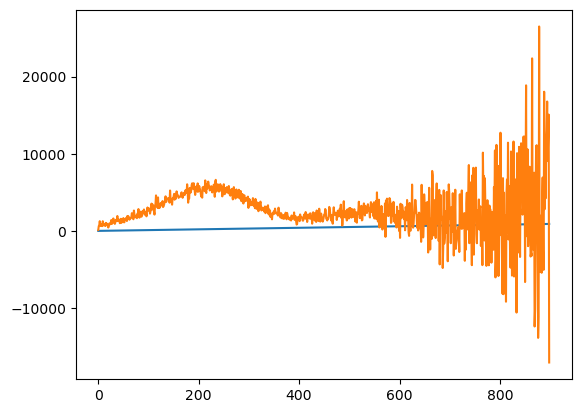

In [3]:
plt.figsize=(20,25)
plt.plot(data)
plt.show()

In [8]:
def power_func(x,d,q):
    G=[]
    x=np.array(x)
    j=1
    for i in range(0,(d+1+q)):
        if i<(d+1):
            G.append(x**i)
        else:
            sottr=900//(q+1)*j
            G.append((np.maximum(0,x-sottr))**d)
            j+=1
            
    return G

In [26]:
G_prova=power_func(data['x'],3,10)
G_prova

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

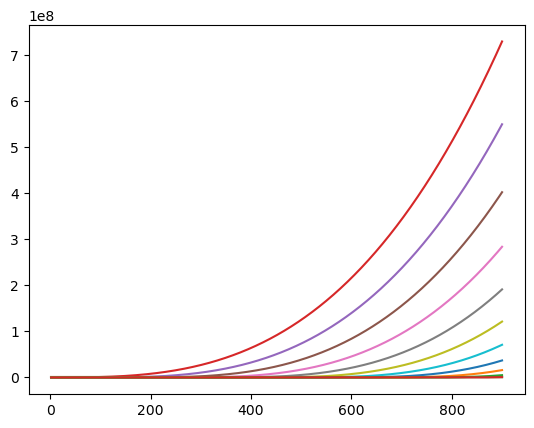

In [10]:
#Plot the loss function
fig=plt.plot(figsize=(25,20))

for i in range(0,14):
    plt.plot(data['x'],G_prova[i])

plt.show()



In [11]:
type(G_prova)

list

In [30]:
def pre_processing(x,d,q):
    mat=power_func(x,d,q)
    mat=np.array(mat)
    return np.transpose(mat)

In [27]:
X=np.array(G_prova)
X=np.transpose(G_prova)

In [32]:
X=pre_processing(data.x,3,10)
print(X)

[[       1        2        4 ...        0        0        0]
 [       1        3        9 ...        0        0        0]
 [       1        4       16 ...        0        0        0]
 ...
 [       1      898   806404 ... 15625000  4826809   681472]
 [       1      899   808201 ... 15813251  4913000   704969]
 [       1      900   810000 ... 16003008  5000211   729000]]


In [35]:
def main (d,q,x=data.x,y=data.y):
    X = pre_processing(x,d,q)
    plm=np.polyfit(X,y,d,full=True)


In [41]:
plm=LinearRegression().fit(X,data.y)
plm.coef_

array([ 0.00000000e+00,  1.34454115e+01,  2.10265813e-02,  4.83023447e-04,
       -1.54557844e-03, -1.47638647e-05,  3.24789786e-03, -1.85170017e-03,
       -1.64363892e-03,  1.49242874e-03,  2.14653866e-04, -2.69894555e-04,
       -2.03415701e-04,  2.83455926e-03])